In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import os
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [2]:
# Hyperparameters
HIDDEN_CHANNELS = 64
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EPOCHS = 100
BATCH_SIZE = 32

In [3]:
# Load the data
def load_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset


In [4]:
# Theoretical saturation throughput calculation
def theoretical_saturation_throughput(transmission_prob, T, sigma, G):
    num_nodes = len(transmission_prob)
    S = np.zeros(num_nodes)

    for i in range(num_nodes):
        p_i = transmission_prob[i]
        prod_other = np.prod([1 - transmission_prob[j] for j in range(num_nodes) if G[i][j] == 1 and j != i])
        numerator = p_i * prod_other * T
        denominator = sigma * prod_other * (1 - p_i) + (p_i * prod_other) * T + (1 - ((prod_other * (1 - p_i)) + p_i * prod_other)) * T

        S[i] = numerator / denominator

    return S

In [33]:
class EnhancedGNN(torch.nn.Module):
    def __init__(self, hidden_channels, input_dim):
        super(EnhancedGNN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(input_dim, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=1, concat=True)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 4)  # Output should be equal to num_nodes

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling
        
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        return x


In [20]:
def process_dataset(dataset, G, T, sigma):
    theoretical_errors = []
    theoretical_st_list = []
    G_flattened = G.flatten()
    
    new_dataset = []
    
    for data in dataset:
        num_nodes = data.x.size(0)
        transmission_prob = data.x[:, 0].numpy()  # Extract only the transmission probabilities
        actual_st = data.y.numpy()
        theoretical_st = theoretical_saturation_throughput(transmission_prob, T, sigma, G)
        theoretical_st_list.append(theoretical_st)
        error = np.abs(actual_st - theoretical_st).mean()  # Use mean error
        theoretical_errors.append(error)
        
        # Normalize transmission probabilities
        normalized_features = transmission_prob
        
        # Append G, T, and sigma to the feature matrix
        new_features = np.hstack([normalized_features, G_flattened, [T], [sigma]])
        new_features = new_features.reshape(1, -1)
        
        new_x = torch.tensor(new_features, dtype=torch.float)
        
        # Update edge_index for the new single node format
        edge_index = torch.tensor([[0, 0, 0, 0], [0, 0, 0, 0]], dtype=torch.long)
        
        new_data = Data(x=new_x, edge_index=edge_index, y=data.y)
        new_dataset.append(new_data)
    
    return new_dataset, theoretical_errors, theoretical_st_list

# Verify the output
filename = 'data/data_100000_samples_4_nodes.pkl'
T = 5
sigma = 1
G = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]
])

num_nodes = G.shape[0]


# Load dataset
dataset = load_data(filename)

# Process dataset to calculate theoretical error, normalize features, and append parameters
dataset, theoretical_errors, theoretical_st_list = process_dataset(dataset, G, T, sigma)
print(f"Average Theoretical Error: {np.mean(theoretical_errors):.4f}")


Average Theoretical Error: 0.0131


In [30]:
# Split the data into train, validation, and test sets
def split_data(dataset, test_size=0.2, val_size=0.1):
    train_val_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=val_size / (1 - test_size), random_state=42)
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = split_data(dataset)
print(f"Train Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

# print("Train Data:")
# print(train_data[0].x)
# print("Validation Data:")
# print(val_data[0].x)
# print("Test Data:")
# print(test_data[0].x)

# Create DataLoader with the new dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)



Train Data: 70000 samples
Validation Data: 10000 samples
Test Data: 20000 samples


In [34]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
        target = data.y.view(out.size(0), -1)  # Ensure target shape matches prediction shape
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_error = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
            target = data.y.view(out.size(0), -1)  # Ensure target shape matches prediction shape
            loss = criterion(out, target)
            total_loss += loss.item()
            total_error += torch.abs(out - target).sum().item()
    return total_loss / len(loader), total_error / len(loader.dataset)


# Initialize model, optimizer, and loss function
input_dim = train_data[0].x.size(1)  # Updated input dimension based on new features
model = EnhancedGNN(hidden_channels=HIDDEN_CHANNELS, input_dim=input_dim)  # Removed num_nodes parameter
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()


In [35]:
# Training loop
train_losses = []
val_losses = []

EPOCHS = 10


for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_error = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Error: {val_error:.4f}')

Epoch 001, Train Loss: 0.0054, Val Loss: 0.0038, Val Error: 0.1621
Epoch 002, Train Loss: 0.0042, Val Loss: 0.0043, Val Error: 0.1767
Epoch 003, Train Loss: 0.0040, Val Loss: 0.0037, Val Error: 0.1583
Epoch 004, Train Loss: 0.0040, Val Loss: 0.0039, Val Error: 0.1622
Epoch 005, Train Loss: 0.0041, Val Loss: 0.0039, Val Error: 0.1663
Epoch 006, Train Loss: 0.0040, Val Loss: 0.0039, Val Error: 0.1583
Epoch 007, Train Loss: 0.0040, Val Loss: 0.0039, Val Error: 0.1584
Epoch 008, Train Loss: 0.0040, Val Loss: 0.0042, Val Error: 0.1727
Epoch 009, Train Loss: 0.0039, Val Loss: 0.0042, Val Error: 0.1670
Epoch 010, Train Loss: 0.0040, Val Loss: 0.0042, Val Error: 0.1640


In [26]:
# Additional evaluation metrics
def additional_metrics(model, loader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
            target = data.y.view(out.size(0), -1)
            all_targets.append(target.numpy())
            all_predictions.append(out.numpy())
    
    all_targets = np.vstack(all_targets).flatten()  # Flatten to 1D
    all_predictions = np.vstack(all_predictions).flatten()  # Flatten to 1D
    
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    
    return mae, r2

# Test the model
test_loss, test_error = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}')

# Calculate additional evaluation metrics
mae, r2 = additional_metrics(model, test_loader)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared: {r2:.4f}')


Test Loss: 0.0066, Test Error: 0.2211
Mean Absolute Error (MAE): 0.0553
R-squared: 0.7342


In [36]:
# Calculate theoretical ST values for the test data
theoretical_st_list_test = []
for data in test_data:
    transmission_prob = data.x[0, :num_nodes].numpy()  # Extract only the transmission probabilities
    theoretical_st = theoretical_saturation_throughput(transmission_prob, T, sigma, G)
    theoretical_st_list_test.append(theoretical_st)  # Store the theoretical ST values

## Calculate predicted ST values for the test data
predicted_st_list = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
        predicted_st_list.extend(out.numpy().flatten())  # Store the values

# Convert lists to numpy arrays and reshape

# Extract actual ST values from the test data
actual_st = [data.y.numpy().flatten() for data in test_data]

# Convert lists to numpy arrays
theoretical_st_list_test = np.array(theoretical_st_list_test)
actual_st = np.array(actual_st)
predicted_st_list = np.array(predicted_st_list).reshape(-1, num_nodes)

# Debug: Print lengths
print("Length of actual_st:", actual_st.shape)
print("Length of theoretical_st_list_test:", theoretical_st_list_test.shape)
print("Length of predicted_st_list:", predicted_st_list.shape)

print("actual_st:", actual_st[0:5])
print("theoretical_st_list_test:", theoretical_st_list_test[0:5])
print("predicted_st_list:", predicted_st_list[0:5])

# Calculate average theoretical error and average predicted error
average_theoretical_error = np.mean(theoretical_errors)
average_predicted_error = np.mean(np.abs(predicted_st_list - actual_st))

print(f'Average Theoretical Error: {average_theoretical_error:.4f}')
print(f'Average Predicted Error: {average_predicted_error:.4f}')


Length of actual_st: (20000, 4)
Length of theoretical_st_list_test: (20000, 4)
Length of predicted_st_list: (20000, 4)
actual_st: [[0.214  0.275  0.1305 0.061 ]
 [0.172  0.007  0.1045 0.007 ]
 [0.125  0.2595 0.002  0.053 ]
 [0.2215 0.0095 0.014  0.0305]
 [0.057  0.0215 0.111  0.2065]]
theoretical_st_list_test: [[0.23477412 0.27951593 0.14825665 0.08912034]
 [0.17499534 0.00624692 0.10565059 0.00505282]
 [0.12137338 0.26615972 0.00221883 0.06699703]
 [0.21643559 0.0100085  0.01966217 0.02680408]
 [0.05959543 0.02319641 0.11358344 0.19883742]]
predicted_st_list: [[ 0.2398971   0.14850785  0.11495188  0.17991568]
 [ 0.16284913 -0.00258973  0.06289174  0.01831125]
 [ 0.178223    0.1403926   0.01905768  0.1883582 ]
 [ 0.26294294  0.03852459  0.03728217  0.06241246]
 [ 0.07269461  0.07454842  0.131015    0.0994825 ]]
Average Theoretical Error: 0.0131
Average Predicted Error: 0.0408


Adjusted length of actual_st: 50
Adjusted length of theoretical_st: 50
Adjusted length of predicted_st: 50


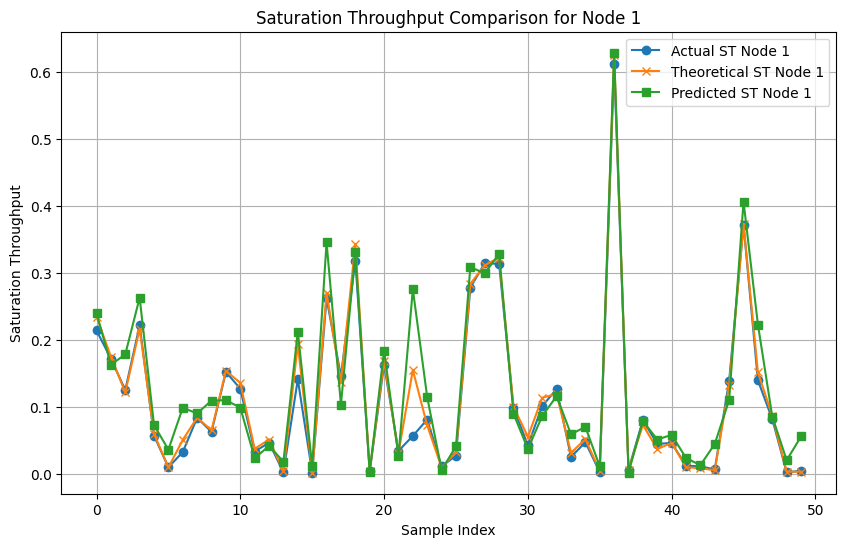

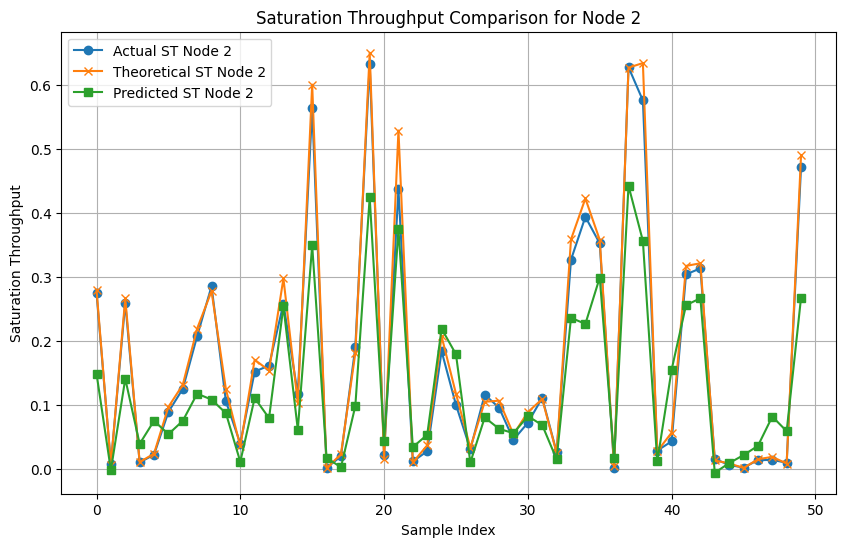

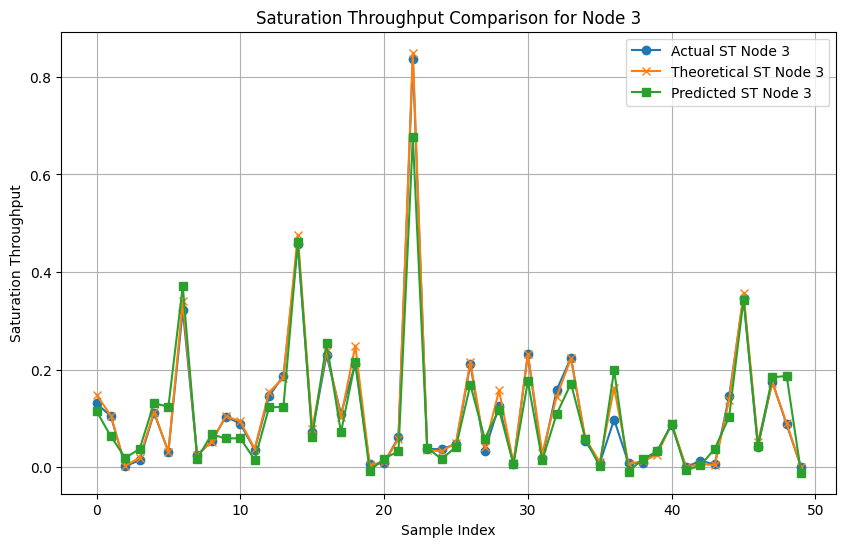

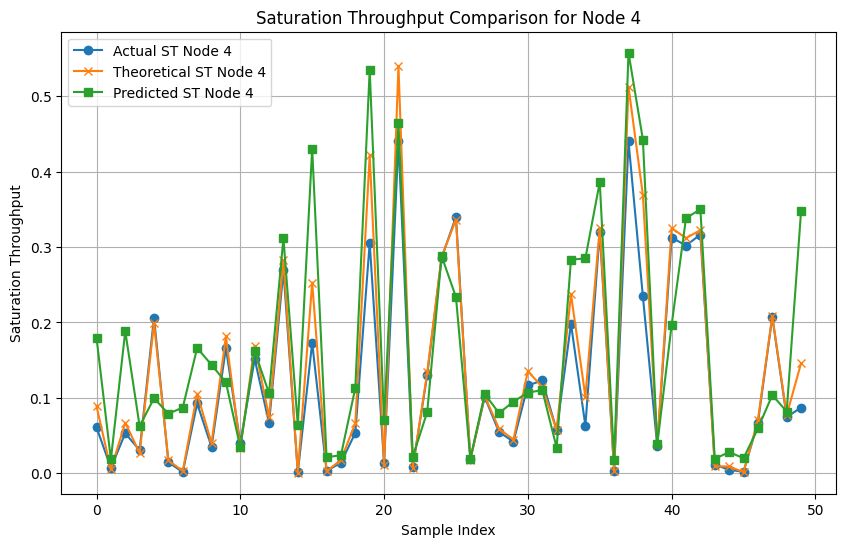

In [38]:
# Plotting function
def plot_results(num_nodes, actual_st, theoretical_st, predicted_st):
    for i in range(num_nodes):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_st[:, i], label=f'Actual ST Node {i+1}', marker='o')
        plt.plot(theoretical_st[:, i], label=f'Theoretical ST Node {i+1}', marker='x')
        plt.plot(predicted_st[:, i], label=f'Predicted ST Node {i+1}', marker='s')
        plt.xlabel('Sample Index')
        plt.ylabel('Saturation Throughput')
        plt.title(f'Saturation Throughput Comparison for Node {i+1}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Ensure all arrays have the same length
min_length = 50
# min_length = min(len(actual_st), len(theoretical_st_list_test), len(predicted_st_list))
actual_st = actual_st[:min_length]
theoretical_st = theoretical_st_list_test[:min_length]
predicted_st = predicted_st_list[:min_length]

# Debug: Print adjusted lengths
print("Adjusted length of actual_st:", len(actual_st))
print("Adjusted length of theoretical_st:", len(theoretical_st))
print("Adjusted length of predicted_st:", len(predicted_st))

# Plot results
plot_results(num_nodes, actual_st, theoretical_st, predicted_st)
